In [1]:
import os
import pandas as pd
import numpy as np


def import_data(detector: str, mass_ratio):
    """Import data computed from scr/rayleigh_criterion_two_modes.py

    Parameters
    ----------
    detector : str
        Gravitational wave detector name. Must be {'LIGO', 'LISA',
        'CE' = 'CE2silicon', 'CE2silica', 'ET'}.
    mass_ratio : TYPE
        Binary black hole mass ratio. mass_ratio >= 1. This is used to
        determine the QNM parameters.

    Returns
    -------
    Pandas DataFrame
        Return DataFrame with the data
    """
    columns = ('mass',
               'redshift',
               'mode_0',
               'mode_1',
               'delta_freq',
               'sigma_freq_0',
               'sigma_freq_1',
               'delta_tau',
               'sigma_tau_0',
               'sigma_tau_1',
               'snr_0',
               'snr_1',
               )

    df = pd.read_csv(
        f'../data/rayleigh_criterion/{detector}_q_{mass_ratio}_rayleigh_criterion.dat', delimiter="\t", comment="#", names=columns)

    return df


def compute_criterion(data_frame):
    """Compute Rayleigh Criterion and SNR > 8 criterion.

    Parameters
    ----------
    data_frame : Pandas DataFrame
        DataFrame imported using 'import_data' function.
    """
    # compute rayleigh criterion
    data_frame['sigma_freq'] = data_frame.apply(
        lambda row: max(row.sigma_freq_0, row.sigma_freq_1), axis=1)
    data_frame['ray_freq'] = data_frame.apply(
        lambda row: np.sign(row.delta_freq - row.sigma_freq) + 1, axis=1)

    data_frame['sigma_tau'] = data_frame.apply(
        lambda row: max(row.sigma_tau_0, row.sigma_tau_1), axis=1)
    data_frame['ray_tau'] = data_frame.apply(
        lambda row: np.sign(row.delta_tau - row.sigma_tau) + 1, axis=1)

    data_frame['rayleigh'] = data_frame.apply(
        lambda row: np.sign(row.ray_freq and row.ray_tau), axis=1)

    # compute SNR > 8
    data_frame['snr_c_0'] = data_frame.apply(
        lambda row: np.sign(row.snr_0 - 8) + 1, axis=1)
    data_frame['snr_c_1'] = data_frame.apply(
        lambda row: np.sign(row.snr_1 - 8) + 1, axis=1)
    data_frame['snr'] = data_frame.apply(
        lambda row: np.sign(row.snr_c_0 and row.snr_c_1), axis=1)

    # both conditions
    data_frame['both'] = data_frame.apply(
        lambda row: np.sign(row.rayleigh and row.snr), axis=1)


def find_horizon_contour(data_frame, modes: tuple):
    """Compute horizon contour

    Parameters
    ----------
    data_frame : Pandas DataFrame
        Description
    modes : tuple
        2d tuple containig mode_0 and mode_1

    Returns
    -------
    list, list
        Returns masses and redshifts at the horizon arrays
    """
    pair = (data_frame.mode_0 == modes[0]) & (
        data_frame.mode_1 == modes[1]) & (data_frame.both == 1)
    df_pair = data_frame[pair]
    X = df_pair.mass
    Y = df_pair.redshift
    Z = df_pair.both
    masses = sorted(set(X))
    redshifts = [max(Y[X == mass]) for mass in masses]
    if len(redshifts) > 0:
        redshifts[0] = min(Y[X == masses[0]])
        redshifts[-1] = min(Y[X == masses[-1]])

    return masses, redshifts


def two_modes_horizons(data_frame, save_df, detector, mass_ratio):
    modes = ['(2,2,1) II', '(3,3,0)', '(4,4,0)', '(2,1,0)']
    two_modes = [('(2,2,0)', mode) for mode in modes]

    for comb in two_modes:
        extra = {}
        extra['masses'],  extra['redshifts'] = find_horizon_contour(
            data_frame, comb)
        if len(extra['masses']) == 0:
            extra['masses'],  extra['redshifts'] = [np.nan] * 2, [np.nan] * 2
        extra['modes'] = [f'{comb}'] * len(extra['masses'])
        extra['detector'] = [detector] * len(extra['masses'])
        extra['mass_ratio'] = [mass_ratio] * len(extra['masses'])
        save_df = save_df.append(pd.DataFrame(extra))

    return save_df



In [2]:
df = import_data('LIGO', 1.5)
compute_criterion(df)

In [3]:
df

,mass,redshift,mode_0,mode_1,delta_freq,sigma_freq_0,sigma_freq_1,delta_tau,sigma_tau_0,sigma_tau_1,...,snr_1,sigma_freq,ray_freq,sigma_tau,ray_tau,rayleigh,snr_c_0,snr_c_1,snr,both
0,41.753189,0.030866,"(2,2,0)","(2,2,1) II",9.378167,1.197764e+01,1.041447e+02,0.001730,1.549690e-03,1.518858e-03,...,8.559113,1.041447e+02,0.0,1.549690e-03,2.0,0.0,2.0,2.0,1.0,0.0
1,16.102620,0.106893,"(2,2,0)","(2,2,1) II",22.646842,6.043051e+02,5.134445e+03,0.000717,1.233411e-02,1.098964e-02,...,0.023483,5.134445e+03,0.0,1.233411e-02,0.0,0.0,0.0,0.0,0.0,0.0
2,12.689610,0.030866,"(2,2,0)","(2,2,1) II",30.857402,4.597901e+02,3.893147e+03,0.000526,4.859282e-03,4.075397e-03,...,0.083695,3.893147e+03,0.0,4.859282e-03,0.0,0.0,0.0,0.0,0.0,0.0
3,20.433597,0.370187,"(2,2,0)","(2,2,1) II",14.417336,5.913125e+02,5.067018e+03,0.001125,3.145144e-02,3.003735e-02,...,0.008798,5.067018e+03,0.0,3.145144e-02,0.0,0.0,0.0,0.0,0.0,0.0
4,32.903446,0.008913,"(2,2,0)","(2,2,1) II",12.159473,6.989865e+00,6.022816e+01,0.001334,5.315180e-04,5.148822e-04,...,43.377634,6.022816e+01,0.0,5.315180e-04,2.0,0.0,2.0,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,7880.462816,0.175686,"(4,4,0)","(2,1,0)",2.318139,1.300162e+04,1.445386e+04,0.016961,4.415666e+04,3.271295e+05,...,0.030104,1.445386e+04,0.0,3.271295e+05,0.0,0.0,0.0,0.0,0.0,0.0
5996,7880.462816,0.225233,"(4,4,0)","(2,1,0)",2.224396,2.863751e+04,2.926163e+04,0.017676,1.183086e+05,6.045860e+05,...,0.017264,2.926163e+04,0.0,6.045860e+05,0.0,0.0,0.0,0.0,0.0,0.0
5997,10000.000000,0.780019,"(4,4,0)","(2,1,0)",1.206585,3.615703e+07,2.041430e+07,0.032586,8.623605e+08,8.116725e+08,...,0.000906,3.615703e+07,0.0,8.623605e+08,0.0,0.0,0.0,0.0,0.0,0.0
5998,7880.462816,0.288753,"(4,4,0)","(2,1,0)",2.114760,6.827905e+04,6.370878e+04,0.018592,3.477994e+05,1.222658e+06,...,0.009793,6.827905e+04,0.0,1.222658e+06,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
from itertools import combinations


In [11]:
modes = ['(2,2,1) II', '(3,3,0)', '(4,4,0)', '(2,1,0)']

In [15]:
three_modes = list(combinations(modes, 2))

In [18]:
df[(df.mode_0 == '(2,2,0)')&(df.mode_1==three_modes[0][0])].reset_index(drop=True).both + df[(df.mode_0 == '(2,2,0)')&(df.mode_1==three_modes[0][1])].reset_index(drop=True).both + df[(df.mode_0 == three_modes[0][0])&(df.mode_1==three_modes[0][1])].reset_index(drop=True).both

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
595    0.0
596    0.0
597    0.0
598    0.0
599    0.0
Name: both, Length: 600, dtype: float64

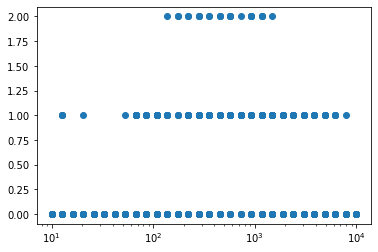

In [26]:
import matplotlib.pyplot as plt
plt.scatter(df[(df.mode_0 == '(2,2,0)')&(df.mode_1==three_modes[0][0])].reset_index(drop=True).mass, df[(df.mode_0 == '(2,2,0)')&(df.mode_1==three_modes[0][0])].reset_index(drop=True).both + df[(df.mode_0 == '(2,2,0)')&(df.mode_1==three_modes[0][1])].reset_index(drop=True).both + df[(df.mode_0 == three_modes[0][0])&(df.mode_1==three_modes[0][1])].reset_index(drop=True).both)
plt.xscale('log')